In [88]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
import numpy as np

In [89]:
import sklearn


# Checking to make sure this updated correctly
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


In [90]:
def survival_rates(df, col):
    return df.groupby(col).Survived.mean().sort_values(ascending=False)

In [91]:
df_train = pd.read_csv('data/titanic/train.csv').set_index('PassengerId')
df_test = pd.read_csv('data/titanic/test.csv').set_index('PassengerId')
data = pd.concat([df_train, df_test], sort=False)

In [92]:
data['Surname'] = data.Name.str.split(', ', expand=True)[0]
data['TicketId'] = data['Ticket'].apply(lambda x: str(x[:-1]))
data['GroupId'] = data.groupby(['Surname', 'Pclass', 'Fare', 'Embarked', 'TicketId']).ngroup()

In [93]:
def deck_feature(df):
    df['Deck'] = df.Cabin.apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.Deck.replace('T', 'M', inplace=True)

def group_decks_by_survival_rate(df):
    df['Deck'].replace(['B','D','E'], 'BDE', inplace=True)
    df['Deck'].replace(['F','C'],'FC', inplace=True)
    df['Deck'].replace(['G','A'],'GA', inplace=True)

def titles(df):
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

    # group related titles together
    df['Title'].replace(['Capt','Col','Major','Dr','Rev'], 'Officer', inplace=True)
    df['Title'].replace(['Jonkheer','Don','Sir','the Countess','Dona','Lady'], 'Royalty', inplace=True)
    df['Title'].replace(['Mme','Ms','Mrs'], 'Married woman', inplace=True)
    df['Title'].replace(['Mlle','Miss'], 'Unmarried woman', inplace=True)
    df['Title'].replace(['Mr'], 'Adult man', inplace=True)
    df['Title'].replace(['Master'], 'Young man', inplace=True)

deck_feature(data)
group_decks_by_survival_rate(data)
titles(data)

In [94]:
# fill missing age by median age of title
def fill_missing_age(df):
    df.Age.fillna(df.groupby('Title').Age.transform('median'), inplace=True)

# fill missing fare and zero fare by median fare of pclass
def fill_missing_fare(df):
    df.loc[df.Fare == 0, 'Fare'] = np.nan
    df.Fare.fillna(df.groupby('Pclass').Fare.transform('median'), inplace=True)

# fill missing embarked by mode
def fill_missing_embarked(df):
    df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)

def fill_zero_fare_to_nan(df):
    df.loc[df.Fare == 0, 'Fare'] = np.nan

fill_missing_age(data)
fill_missing_embarked(data)
fill_zero_fare_to_nan(data)

In [95]:
data['FamilyTitle'] = 'man'
data.loc[data['Sex'] == 'female', 'FamilyTitle'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'FamilyTitle'] = 'boy'

data.loc[data['FamilyTitle'] == 'man', 'GroupId'] = -1
data['GroupFreq'] = data.groupby('GroupId')['GroupId'].transform('count')
data['GroupId'] = data['GroupId'].where(data['GroupFreq'] > 1, -1)
data['TicketId'] = data.groupby(['Pclass', 'Fare', 'Embarked', 'FamilyTitle', 'TicketId']).ngroup()

count = 0
names = []
for i in data[(data['FamilyTitle'] != 'man') & (data['GroupId'] == -1)].index:
    x = data[data['TicketId'] == data.loc[i, 'TicketId']]['GroupId'].values
    if x.size > 0:
        m = max(x)
        if m != -1:
            data.loc[i, 'GroupId'] = m
            # print family surname of people with same ticket
            names.append(data.loc[data['GroupId'] == m, 'Surname'].values[0])
            count += 1

print(f"We found {count} nannies/relatives and added them to groups.")
print(sorted(names))

We found 11 nannies/relatives and added them to groups.
['Allison', 'Allison', 'Cacic', 'Davies', 'Panula', 'Ryerson', 'Ryerson', 'Spedden', 'Spedden', 'Wick', 'Zabour']


In [96]:
data['GroupSurvival'] = None
data['Survived'] = data['Survived'].astype(float)

data.loc[0:891, 'GroupSurvival'] = data.groupby('GroupId')['Survived'].transform('mean')

for i in range(892, 1310):
    group_id = data.loc[i, 'GroupId']
    data.loc[i, 'GroupSurvival'] = data.loc[data['GroupId'] == group_id, 'GroupSurvival'].iloc[0]

data.loc[(data['GroupSurvival'].isnull()) & (data['Pclass'] == 3), 'GroupSurvival'] = 0
data.loc[(data['GroupSurvival'].isnull()) & (data['Pclass'] != 3), 'GroupSurvival'] = 1

data['Predict'] = 0
data.loc[data['Sex'] == 'female', 'Predict'] = 1
data.loc[(data['FamilyTitle'] == 'woman') & (data['GroupSurvival'] == 0), 'Predict'] = 0
data.loc[(data['FamilyTitle'] == 'boy') & (data['GroupSurvival'] == 1), 'Predict'] = 1

In [97]:
boy_lived = data.loc[(data['Sex'] == 'male') & (data['Predict'] == 1) & (data.index > 891), ['Name', 'FamilyTitle']]
print(f'{len(boy_lived)} boys predicted to live')
print(boy_lived, '\n')
female_die = data.loc[(data['Sex'] == 'female') & (data['Predict'] == 0) & (data.index > 891), ['Name', 'FamilyTitle']]
print(f'{len(female_die)} females predicted to die')
print(female_die)

8 boys predicted to live
                                        Name FamilyTitle
PassengerId                                             
956              Ryerson, Master. John Borie         boy
981              Wells, Master. Ralph Lester         boy
1053          Touma, Master. Georges Youssef         boy
1086           Drew, Master. Marshall Brines         boy
1088         Spedden, Master. Robert Douglas         boy
1199               Aks, Master. Philip Frank         boy
1284           Abbott, Master. Eugene Joseph         boy
1309                Peter, Master. Michael J         boy 

15 females predicted to die
                                                          Name FamilyTitle
PassengerId                                                               
910                               Ilmakangas, Miss. Ida Livija       woman
925          Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"       woman
929                                         Cacic, Miss. Manda       woman


In [98]:
data['FamilySize&Age'] = data['SibSp'] + data['Parch'] + 1 + data['Age'] / 70


def fill_zero_fare_to_nan(df):
    df.loc[df.Fare == 0, 'Fare'] = np.nan


fill_zero_fare_to_nan(data)
# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

In [99]:
submit = pd.DataFrame({'PassengerId': data.loc[892:1309].index, 'Survived': data.loc[892:1309, 'Predict'].astype(int)})
submit.to_csv('gender_model.csv', index=False)

* **PassengerId** is the unique id of the row and it doesn't have any effect on target
* **Survived is** the target variable we are trying to predict (0 or 1):
    * 1 = Survived
    * 0 = Not Survived
* **Pclass** (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    * 1 = Upper Class
    * 2 = Middle Class
    * 3 = Lower Class
* **Name, Sex and Age** are self-explanatory
* **SibSp** is the total number of the passengers' siblings and spouse
* **Parch** is the total number of the passengers' parents and children
* **Ticket** is the ticket number of the passenger
* **Fare** is the passenger fare
* **Cabin** is the cabin number of the passenger
* **Embarked** is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [100]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

In [101]:
male_mask = (data['Sex'] == 'male') & (data['GroupId'] == -1)
train_male = data[0:891].loc[male_mask]
test_male = data[891:1309].loc[male_mask]
print(len(train_male))
print(len(test_male))

537
247


In [102]:
test_male

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,GroupId,Deck,Title,FamilyTitle,GroupFreq,GroupSurvival,Predict,FamilySize&Age,Ticket_freq,Pfare
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,1.492857,1,7.829200
894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,1.885714,1,9.687500
895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,1.385714,1,8.662500
897,NaN,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,1.200000,1,9.225000
899,NaN,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,3.371429,3,9.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,NaN,2,"Ware, Mr. William Jeffery",male,23.0,1,0,28666,10.5000,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,2.328571,1,10.500000
1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,...,-1.0,FC,Adult man,man,782.0,0.337415,0,3.714286,5,42.300000
1305,NaN,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,...,-1.0,M,Adult man,man,782.0,0.337415,0,1.414286,1,8.050000


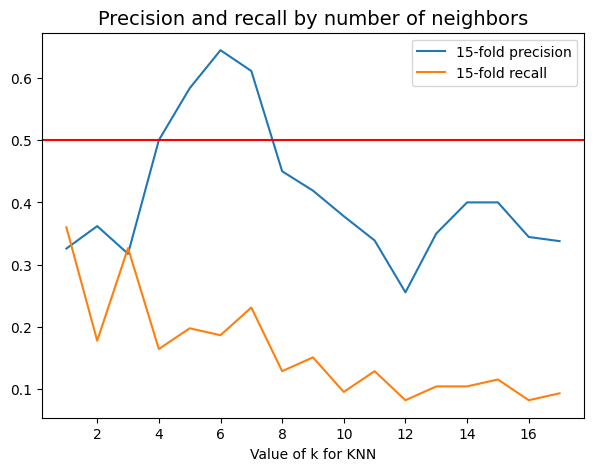

In [103]:
cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
features = ['Pfare', 'Pclass', 'Embarked']
numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

y_m = train_male['Survived']
X_m = train_male[features]


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())

k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [104]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)

male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', VotingClassifier(estimators=[('m1', m1), ('m2', m2), ('m3', m3)]))
])

male_pipeline.fit(X_m, y_m)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pfare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Embarked'])])),
                ('model',
                 VotingClassifier(estimators=[('m1',
                                               KNeighborsClassifier(n_neighbors=1)),
                                              ('m2',
                                               KNeighborsClassifier(n_neighbors=3)),
                                              ('m3',
                                               KNeighborsClassifier(n_neighbors=7))]))])

In [105]:
import numpy as np
X_test_m = test_male[features]
predictions = male_pipeline.predict(X_test_m)
# predictions = np.where(predictions >= 0.70, 1, 0)
print('\nThe following 9 adult males are predicted to live:')
print(len(test_male.loc[predictions == 1]))
data.loc[892:1309][male_mask][predictions == 1][['Name', 'Pclass', 'Pfare']]


The following 9 adult males are predicted to live:
13


C:\Users\tomas\AppData\Local\Temp\ipykernel_1756\4019571106.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.loc[892:1309][male_mask][predictions == 1][['Name', 'Pclass', 'Pfare']]


,Name,Pclass,Pfare
PassengerId,,,
920,"Brady, Mr. John Bertram",1,30.500000
926,"Mock, Mr. Philipp Edmund",1,28.875000
931,"Hee, Mr. Ling",3,7.061975
942,"Smith, Mr. Lucien Philip",1,30.000000
960,"Tucker, Mr. Gilbert Milligan Jr",1,28.537500
986,"Birnbaum, Mr. Jakob",1,26.000000
987,"Tenglin, Mr. Gunnar Isidor",3,7.795800
1018,"Brobeck, Mr. Karl Rudolf",3,7.795800
1023,"Gracie, Col. Archibald IV",1,28.500000


In [106]:
data.loc[892:1309, 'Predict'][male_mask] = predictions
submit = pd.DataFrame({'PassengerId': data.loc[892:1309].index, 'Survived': data.loc[892:1309, 'Predict'].astype(int)})
submit.to_csv('gender_model2.csv', index=False)

In [107]:
# female
female_mask = (data['Sex'] == 'female') & (data['GroupId'] == -1) & (data['Pclass'] == 3)
train_female = data[0:891].loc[female_mask]
test_female = data[891:1309].loc[female_mask]
print(len(train_female))
print(len(test_female))

77
46


In [108]:
test_female.to_csv('xd.csv')

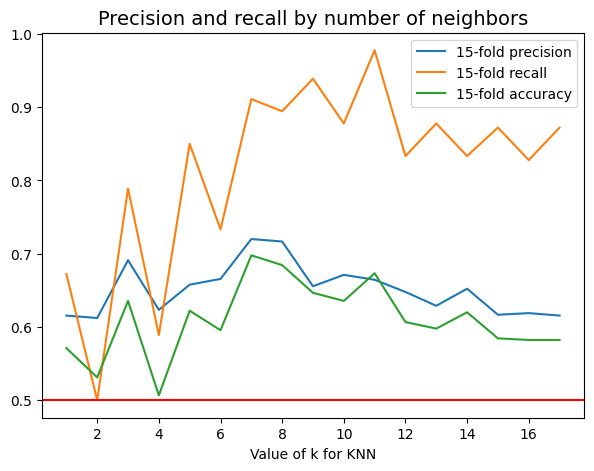

In [109]:
features = ['Pfare', 'Age', 'Title', 'Deck']
numerical_cols = ['Pfare', 'Age']
categorical_cols = ['Title', 'Deck']

X_m = train_female[features]
y_m = train_female['Survived']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []
error = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    error.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='accuracy').mean())

k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.plot(k_range, error, label='15-fold accuracy')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [110]:
from sklearn.ensemble import RandomForestClassifier
m1 = KNeighborsClassifier(n_neighbors=3)
m2 = KNeighborsClassifier(n_neighbors=7)
m3 = KNeighborsClassifier(n_neighbors=8)

female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', VotingClassifier(estimators=[('m1', m1), ('m2', m2), ('m3', m3)]))
])

female_pipeline.fit(X_m, y_m)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pfare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title', 'Deck'])])),
                ('model',
                 VotingClassifier(estimators=[('m1',
                                               KNeighborsClassifier(n_neighbors=3)),
                                              ('m2',
                                               KNeighborsClassifier(n_neighbors=7)),
                                              ('m3',
                                               KNeighborsClassifier(n_neighbors=8))]))])

In [111]:
X_test_m = test_female[features]
predictions = female_pipeline.predict(X_test_m)
# predictions = np.where(predictions <= 0.25, 0, 1)
print(len(test_female.loc[predictions == 0]))
data.loc[892:1309][female_mask][predictions == 0][['Name', 'Pclass', 'Pfare']]

13


C:\Users\tomas\AppData\Local\Temp\ipykernel_1756\1793754188.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.loc[892:1309][female_mask][predictions == 0][['Name', 'Pclass', 'Pfare']]


,Name,Pclass,Pfare
PassengerId,,,
893,"Wilkes, Mrs. James (Ellen Needs)",3,7.00000
898,"Connolly, Miss. Kate",3,7.62920
911,"Assaf Khalil, Mrs. Mariana (Miriam"")""",3,7.22500
964,"Nieminen, Miss. Manta Josefina",3,7.92500
978,"Barry, Miss. Julia",3,7.87920
1061,"Hellstrom, Miss. Hilda Maria",3,8.96250
1098,"McGowan, Miss. Katherine",3,7.75000
1106,"Andersson, Miss. Ida Augusta Margareta",3,7.77500
1183,"Daly, Miss. Margaret Marcella Maggie""""",3,6.95000


In [112]:
data.loc[892:1309, 'Predict'][female_mask] = predictions
submit = pd.DataFrame({'PassengerId': data.loc[892:1309].index, 'Survived': data.loc[892:1309, 'Predict'].astype(int)})
submit.to_csv('gender_model3.csv', index=False)